**Table of contents**<a id='toc0_'></a>        
  - [1. An Introduction to Time Series Forecasting with Python](#toc1_2_)    
    - [1.1 Problem Statement](#toc1_2_1_)    
    - [1.2 Load the data into Pandas DataFrame](#toc1_2_2_)    
    - [1.3 Visualize the data](#toc1_2_3_)    
  - [2. Trend and Seasonality](#toc1_3_)    
    - [2.1 The Trend](#toc1_3_1_)    
    - [2.2 The Seasonality](#toc1_3_2_)    
    - [2.3 The Residual](#toc1_3_3_)    
  - [3. Facebook Prophet Model](#toc1_4_)    
    - [3.1 Specifying Seasonalities](#toc1_4_1_)    
    - [3.2 Holidays and Special Events](#toc1_4_2_)    
    - [3.3 Make prediction](#toc1_4_3_)    
    - [3.4 Evaluate the forecast](#toc1_4_4_)    
-  [4. Holt-Winters Model](#toc2_)    
-  [5. ARIMA Model](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

*We are using this code snippet below to set up default styling for matplotlib plots to ensure that they have consistent visual properties like font size, figure size, and line width. It's useful for ensuring that your plots have a uniform appearance when working on data visualization tasks.*

In [1]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

## <a id='toc1_2_'></a>[1. An Introduction to Time Series Forecasting with Python](#toc0_)
Time series analysis is an important instrument to model, analyze and predict data collected over time. In this talk, we learn the basic theoretical concepts without going deep into mathematical aspects, study different models, and try them in practice using StatsModels, Prophet,and scikit-learn.

### <a id='toc1_2_1_'></a>[1.1 Problem Statement](#toc0_)

We are going to analyse a dataset for overseas visits to UK and would try to use different mathematical models to analyse the same.

 <a id='toc1_2_2_'></a>[OS visits to UK (All visits)](#toc0_)

The dataset represents the monthly total number of visits to the UK by overseas residents (in thousands) from January 1980 to October 2017.
<a id='toc1_2_2_1_'></a>

Source: [Office for National Statistics]
(https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/timeseries/gmaa/ott)  

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [3]:
import warnings
warnings.filterwarnings('ignore')

### <a id='toc1_2_2_'></a>[1.2 Load the data into Pandas DataFrame](#toc0_)

In [4]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Indigo Training - Feb 2025/Indigo Training - 2025/To Be Shared with Indigo team/Machine Learning/Exercises for Indigo/Time Series Forecasting/GMAA-040218.csv", header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
df.value.astype(int, copy=False);

In [6]:
df.head(5)

,period,value
0,1980-01-01,739
1,1980-02-01,602
2,1980-03-01,740
3,1980-04-01,1028
4,1980-05-01,1088


In [7]:
max_date = df.period.max()
min_date = df.period.min()

num_of_actual_points = df.index.shape[0]
num_of_expected_points = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month + 1

print("Date range: {} - {}".format(min_date.strftime("%d.%m.%Y"), max_date.strftime("%d.%m.%Y")))
print("Number of data points: {} of expected {}".format(num_of_actual_points, num_of_expected_points))


Date range: 01.01.1980 - 01.10.2017
Number of data points: 454 of expected 454


In [8]:
import numpy as np

train_range = df[df.period < '2014-01-01'].index
test_range = df[(df.period >= '2014-01-01')].index

### <a id='toc1_2_3_'></a>[1.3 Visualize the data](#toc0_)

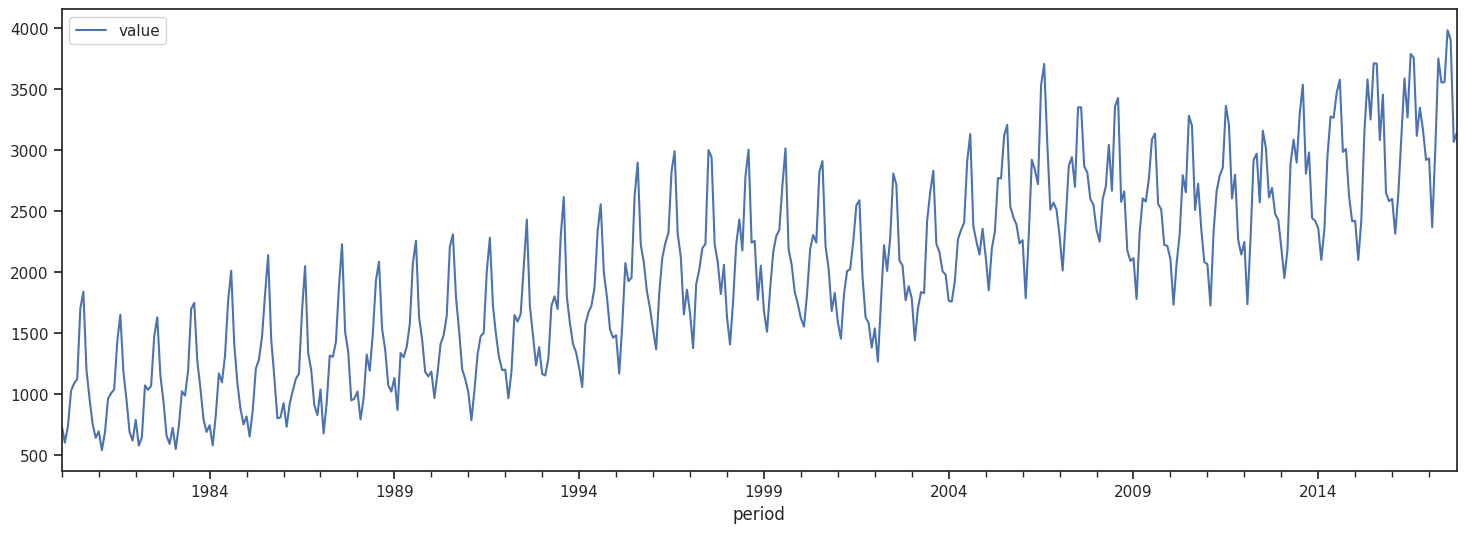

In [9]:
fig, ax = plt.subplots(figsize=(18,6))
df.plot(x="period", y="value", ax=ax)
plt.legend(loc='upper left')

In **2001** a combination of the outbreak of foot and mouth disease and the September 11 attacks in the US led to a dramatic slump.

In **2009** the global economic crisis, which started to bite in earnest in the autumn, was blamed as a factor for the fall.

https://www.theguardian.com/business/2009/jul/16/tourism-uk-visitors-fall

In 2006 total visits to the UK by overseas residents were split fairly
equally between three purposes: holiday, visiting friends or relatives,
and business. This pattern is quite different compared with ten years
ago, when ‘holiday’ was the dominant reason

https://www.ons.gov.uk/ons/rel/ott/travel-trends/2006/travel-trends---2006.pdf

The majority of visitors were from North America, followed by tourists from France and Germany.
http://www.bbc.com/news/uk-england-london-27323755

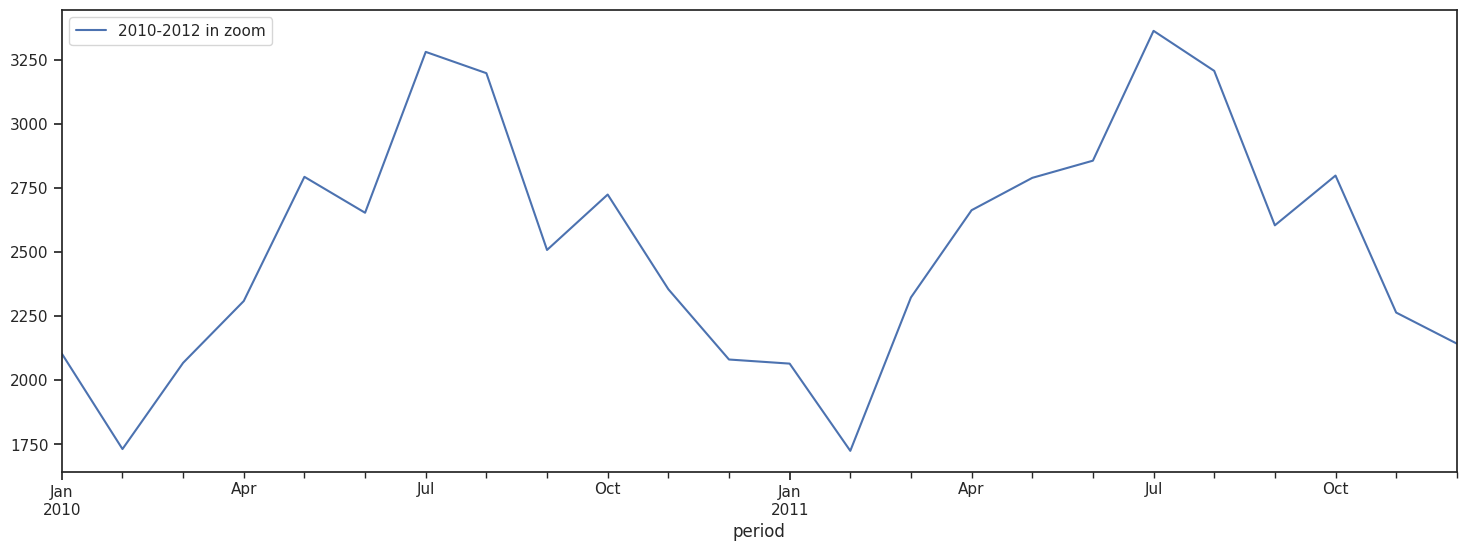

In [10]:
zoom_range = df[(df.period >= '2010-01-01') & (df.period < '2012-01-01')].index

fig, ax = plt.subplots(figsize=(18,6))
df.loc[zoom_range].plot(x="period", y="value", ax=ax, label="2010-2012 in zoom")
plt.legend(loc='upper left')

## <a id='toc1_3_'></a>[2. Trend and Seasonality](#toc0_)

From the visualization it's already quite obvious that the OS visits have periodic fluctuations each year and overall tendency to grow up.

In time series analysis, "trend" and "seasonality" are important components that describe patterns and variations in the data over time.

**Trend**:
A trend refers to the long-term movement or behavior of a time series data over an extended period of time. It represents the underlying direction or tendency of the data as it changes over time. A trend can be upward, downward, or relatively flat. Trends can be caused by various factors such as economic changes, population growth, technological advancements, etc. Detecting and understanding trends in a time series can provide insights into the overall behavior and potential future trajectories of the data.

**Seasonality**:
Seasonality refers to the repeating patterns or variations that occur in a time series at regular intervals. These intervals are often associated with specific time periods, such as days, weeks, months, or seasons. Seasonal patterns are typically driven by external factors like weather, holidays, cultural events, and other periodic influences. Detecting and analyzing seasonality is crucial for understanding the cyclic behavior of the data and making informed decisions based on recurring patterns.

In summary, trends capture the long-term changes in a time series data, while seasonality accounts for regular, repeating patterns that occur within shorter intervals. Both trend and seasonality are essential components to consider when analyzing and modeling time series data, as they help in understanding the underlying dynamics and making accurate predictions.

Thus, we can conclude that the time series has the **trend** and yearly **seasonality** components, and we can try to decompose them them using, for instance, **statsmodels** package.

Note, from the data view we also can suspect that **additive** model better fits for data representation.

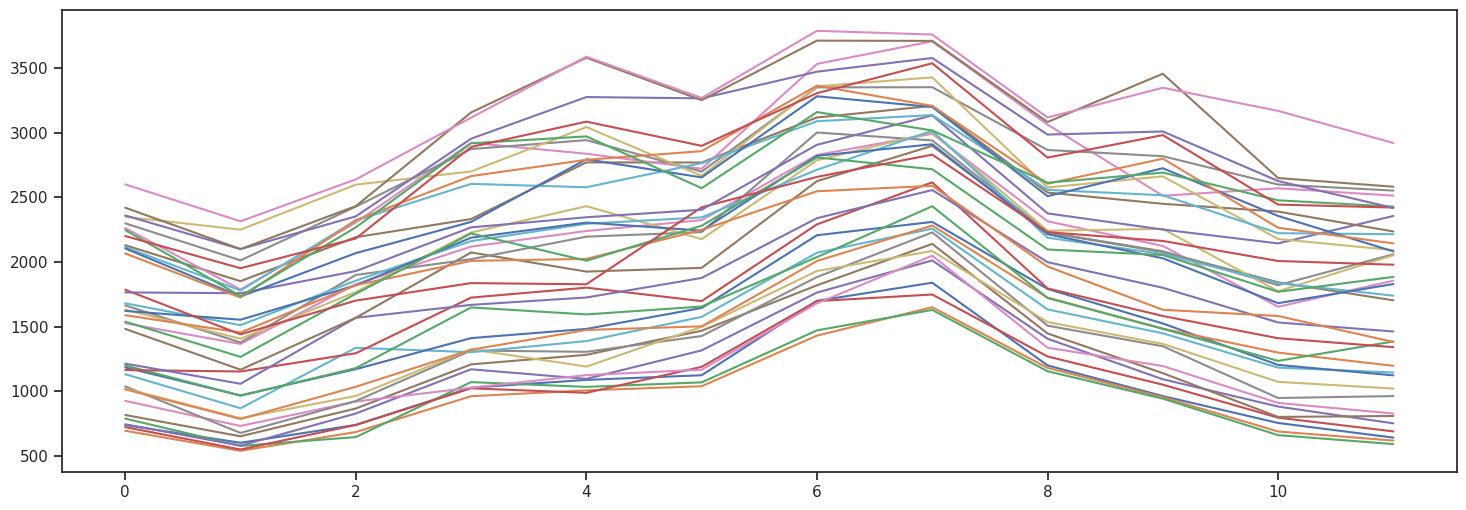

In [11]:
ts = df.set_index('period').squeeze()
for i in range(1980,2017):
    x = list(ts[str(i)])
    plt.plot(x,label=str(i))
#plt.legend()
plt.show()

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 12  # 12 months seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("period").value.interpolate("linear"),
    period=decompfreq,
    model=model)

In [13]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

### <a id='toc1_3_1_'></a>[2.1 The Trend](#toc0_)

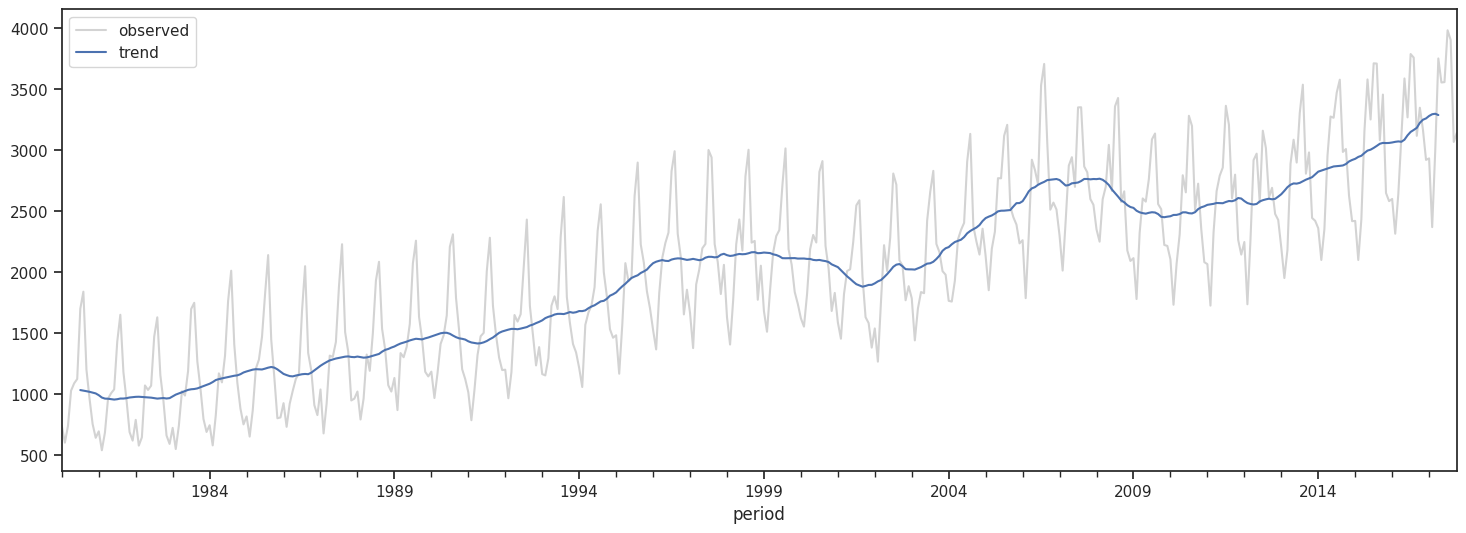

In [14]:
fig, ax = plt.subplots(figsize=(18,6))
df.plot(x="period", y="value", ax=ax, label="observed", c='lightgrey')
trend.plot(ax=ax, label="trend")
plt.legend(loc='upper left')

### <a id='toc1_3_2_'></a>[2.2 The Seasonality](#toc0_)

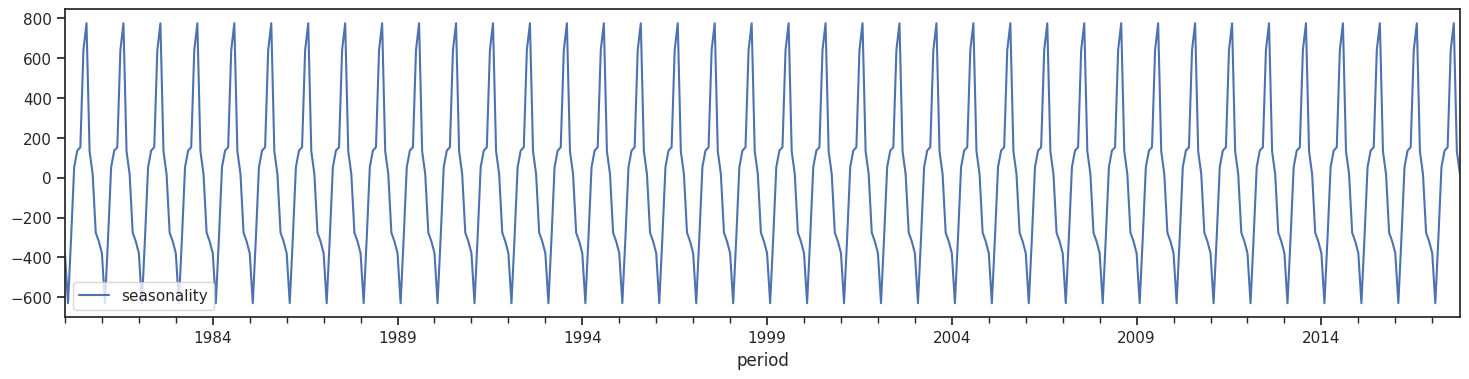

In [15]:
fig, ax = plt.subplots(figsize=(18,4))
seasonal.plot(ax=ax, label="seasonality")
plt.legend(loc='lower left')

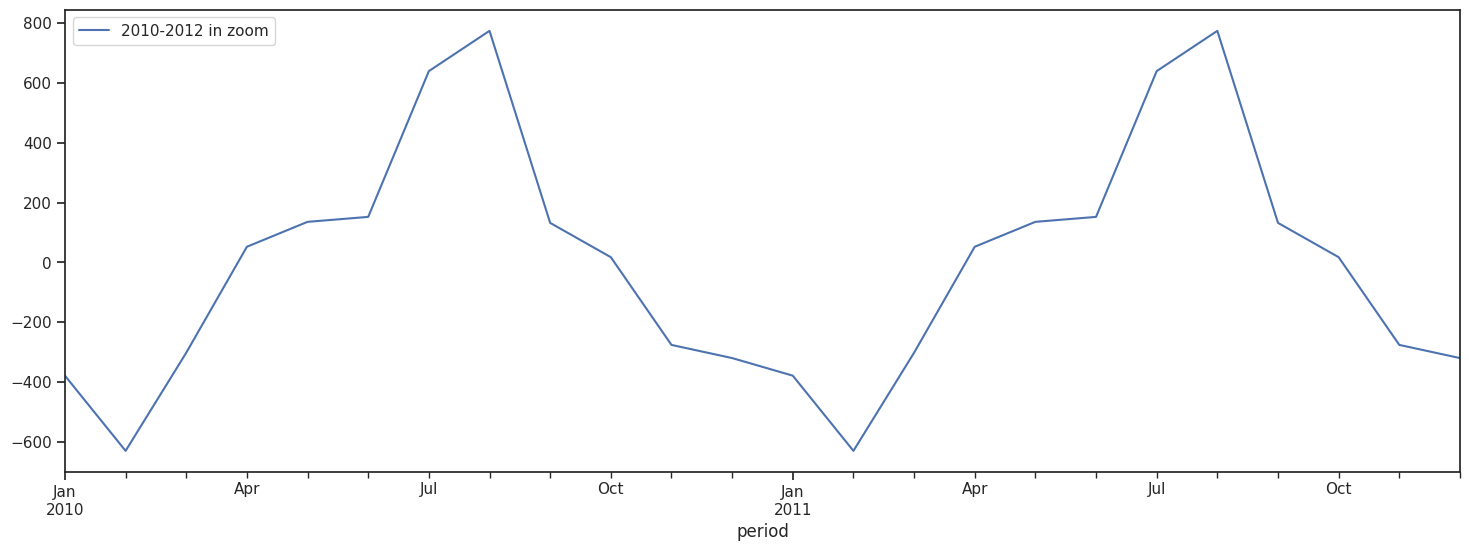

In [16]:
fig, ax = plt.subplots(figsize=(18,6))
seasonal[zoom_range].plot(x="period", y="value", ax=ax, label="2010-2012 in zoom")
plt.legend(loc='upper left')

### <a id='toc1_3_3_'></a>[2.3 The Residual](#toc0_)

Let us try to understand what residuals are and why it important in machine learning

Residuals are the differences between the observed values and the corresponding predicted values in a time series analysis. In the context of time series modeling, residuals are essential for several reasons:

**Model Validity**: Residuals can be used to assess the adequacy and validity of a time series model. A good model should capture the underlying patterns and variations in the data, leaving behind only random noise in the residuals. If the residuals exhibit patterns or structure, it indicates that the model is not capturing all the relevant information in the data and might need improvement.

**Model Assumptions**: Many time series models assume that the residuals are independent, identically distributed, and have constant variance (homoscedasticity). Checking the residuals can help you assess whether these assumptions hold true for your chosen model. If the assumptions are violated, it might indicate that the model's assumptions don't align well with the data.

**Detection of Misspecification**: Residual analysis can help identify cases of model misspecification. If there are systematic patterns in the residuals (e.g., consistent overestimation or underestimation), it might suggest that the model is not capturing certain features of the data, like trend, seasonality, or other relevant factors.

**Outliers and Anomalies**: Residuals can reveal the presence of outliers or anomalies in the data. Large and persistent residuals might indicate instances where the model is struggling to explain unusual or unexpected observations.

**Model Improvement**: By examining the patterns in the residuals, you can get insights into what aspects of the data your model is not capturing. This information can guide you in refining your model by introducing additional terms, adjusting parameters, or incorporating new features.

**Plotting residuals** is a common practice in time series analysis for the reasons mentioned above. There are a few specific types of plots that are often used to visualize residuals:

In summary, residuals are crucial in time series analysis as they provide valuable insights into the adequacy of the chosen model, model assumptions, and potential areas for improvement. Plotting residuals helps to visually identify patterns, anomalies, and deviations from model assumptions, which are essential for making informed decisions about the quality of your time series model.

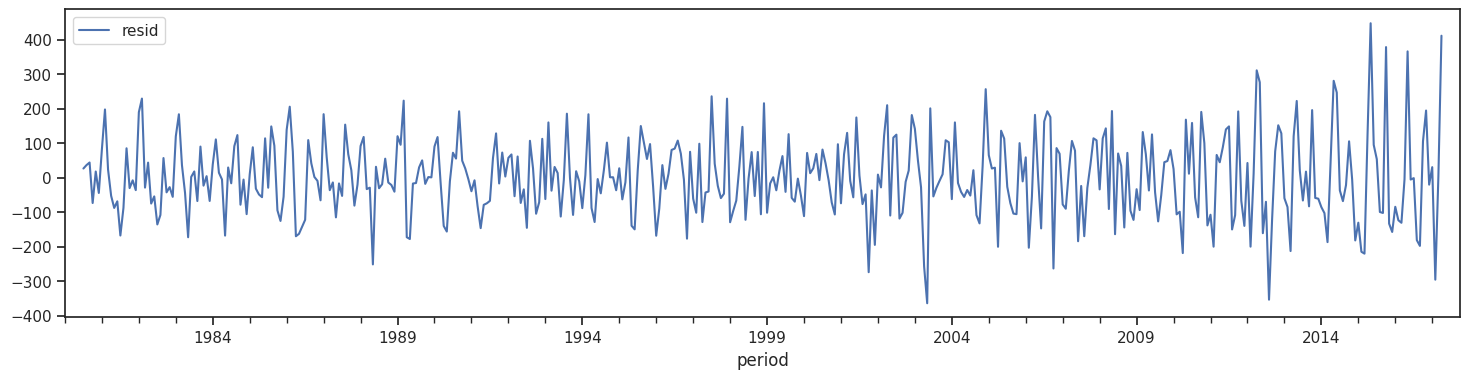

In [17]:
fig, ax = plt.subplots(figsize=(18,4))
residual.plot(ax=ax, legend="seasonality")
plt.legend(loc='upper left')

## <a id='toc1_4_'></a>[3. Facebook Prophet Model](#toc0_)

Prophet is a procedure for forecasting time series data. It is designed to handle both additive and multiplicative seasonality where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers.

$$X(t) = T(t) + S(t) + H(t) + \varepsilon_t$$

<a id='toc1_4_1_1_1_'></a>[<small>$T(t)$ - trend, $S(t)$ - seasonal effects, $H(t)$  - holidays (potentially irregular), $\varepsilon_t$ - unpredicted effects.</small>](#toc0_)

Here's an overview of the key features and components of the Facebook Prophet model:

**Components of Prophet Model**:

**Trend**: Prophet models the underlying trend in the data using a piecewise linear or logistic growth curve. It can capture various types of trends, including linear, saturating, and abrupt changes.

**Seasonality**: Prophet accommodates both yearly and weekly seasonality. It can also handle holidays and special events that affect seasonality.

**Holiday Effects**: Special events and holidays can be incorporated as custom seasonalities to account for their impact on the time series data.

**Regressors**: External regressors can be included in the model to capture additional factors that might influence the target time series.
Flexibility and Ease of Use:

Prophet is designed to handle large datasets efficiently and can produce forecasts quickly, making it suitable for scenarios where real-time or batch forecasting is required.
Visualization:

Prophet provides built-in visualization tools to visualize the data, trend, seasonality, and forecasted values.

The steps to use the Prophet model generally involve:

**Loading Data**: Preparing your time series data in the proper format, including the timestamp and target value columns.

**Initializing Model**: Creating a Prophet model instance and optionally specifying any holidays, regressors, or additional parameters.

**Fitting Model**: Fitting the model to your training data using the fit method.

**Making Predictions**: Using the make_future_dataframe method to create a future time range for forecasting, and then using the predict method to obtain forecasted values.

**Visualizing Results**: Visualizing the historical data, trend, seasonality, and forecasted values using the built-in plotting capabilities.

Prophet is a popular choice for time series forecasting due to its simplicity, flexibility, and ability to handle a variety of time series patterns and effects.

In [18]:
#!pip install pystan

In [19]:
!pip install prophet

In [20]:
from prophet import Prophet

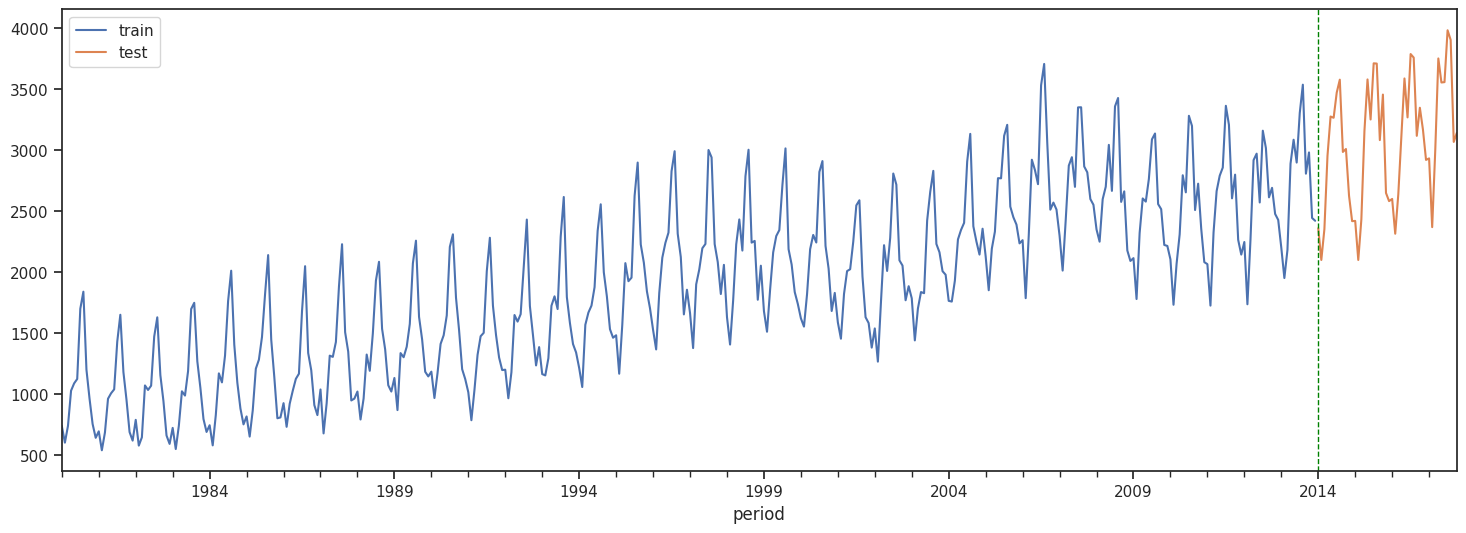

In [21]:
fig, ax = plt.subplots(figsize=(18,6))
df.loc[train_range].plot(x="period", y="value", ax=ax, label="train")
df.loc[test_range].plot(x="period", y="value", ax=ax, label="test")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='green', ls='--', lw=1)
plt.legend(loc='upper left')

### <a id='toc1_4_1_'></a>[3.1 Specifying Seasonalities](#toc0_)
Prophet by default can fit weekly and yearly seasonalities, if the time series is more than two cycles long. However, it's possiblIt to add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method.

### <a id='toc1_4_2_'></a>[3.2 Holidays and Special Events](#toc0_)
Prophet allows to include holidays and other special events. It must include all occurrences of the holiday, both in the past and in the future (out as far as the forecast is being made). If they won't repeat in the future, Prophet will model them and then not include them in the forecast.


https://en.wikipedia.org/wiki/Tourism_in_the_United_Kingdom

Top 3 countries visiting UK: FR, US, DE

In [22]:
import holidays

years = range(1980, 2017)

uk_holidays = holidays.UK(years=years)

visitors_holidays = holidays.FRA(years=years) +\
    holidays.US(years=years) +\
    holidays.DE(years=years)

all_holidays = uk_holidays + visitors_holidays

In [23]:
df_holidays = pd.DataFrame.from_dict(all_holidays, orient="index").reset_index()
df_holidays.columns = ["ds", "holiday"]

In [24]:
df_holidays.head()

,ds,holiday
0,1980-04-04,Good Friday
1,1980-05-05,May Day
2,1980-05-26,Memorial Day; Spring Bank Holiday; Whit Monday
3,1980-01-01,New Year's Day
4,1980-12-25,Christmas Day


In [25]:
from datetime import date

changepoints = {
    date(2001,9,11): "September 11 attacks in the US",
    date(2008,9,15): "Start of the Global Financial Crisis",
    date(2009,8,1): "End of the Global Financial Crisis"
}

In [26]:
df_prophet_train = df.loc[train_range][["period", "value"]]
df_prophet_train.columns = ["ds", "y"]

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoints=list(changepoints.keys()),
    holidays=df_holidays,
    mcmc_samples=12,
    growth='linear',
    interval_width=0.9)

In [27]:
model.fit(df_prophet_train);

DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok6_41rq/vxekh02q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok6_41rq/b53483ei.json
23:09:47 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=16485', 'data', 'file=/tmp/tmpok6_41rq/vxekh02q.json', 'init=/tmp/tmpok6_41rq/b53483ei.json', 'output', 'file=/tmp/tmpok6_41rq/prophet_modelztmzdgxl/prophet_model-20250206230947_1.csv', 'method=sample', 'num_samples=6', 'num_warmup=6', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=16485', 'data', 'file=/tmp/tmpok6_41rq/vxekh02q.json', 'init=/tmp/tmpok6_41rq/b53483ei.json', 'output', 'file=/tmp/tmpok6_41rq/prophet_modelztmzdgxl/prophet_model-20250206230947_2.csv', 'method=sample', 'num_samples=6', 'num_warmup=6', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:ru

23:09:47 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=16485', 'data', 'file=/tmp/tmpok6_41rq/vxekh02q.json', 'init=/tmp/tmpok6_41rq/b53483ei.json', 'output', 'file=/tmp/tmpok6_41rq/prophet_modelztmzdgxl/prophet_model-20250206230947_1.csv', 'method=sample', 'num_samples=6', 'num_warmup=6', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpok6_41rq/prophet_modelztmzdgxl/prophet_model-20250206230947_1.csv
 console_msgs (if any):
	/tmp/tmpok6_41rq/prophet_modelztmzdgxl/prophet_model-20250206230947_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 6
    num_warmup = 6
    save_warmup = 0 (Default)
    thin = 1 (Default)
    

### <a id='toc1_4_3_'></a>[3.3 Make prediction](#toc0_)

In [28]:
# forecasting the trend of visitors from the year 2014 to 2017
df_prophet_test = df.loc[test_range][["period", "value"]]
df_prophet_test.columns = ["ds", "y"]

forecast = model.predict(df_prophet_test[['ds']])
# forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

# yhat_test = forecast.yhat.values
# y_test = df.loc[test_range].value.values

In [29]:
forecast


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Armistice Day; Veterans Day,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,2992.323501,1000.572990,4469.842231,2867.852129,3137.144440,0.000000,0.000000,0.000000,0.0,...,-155.072015,-523.142295,53.195279,-325.923176,-713.515213,256.936896,0.0,0.0,0.0,2511.328309
1,2014-02-01,2997.068738,807.231443,4467.347848,2871.079726,3143.231033,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,-514.102148,-674.281881,-245.030697,0.0,0.0,0.0,2482.966589
2,2014-03-01,3001.354758,1478.415817,4854.074544,2873.994975,3148.728602,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,-189.184558,-425.301731,80.031203,0.0,0.0,0.0,2812.170200
3,2014-04-01,3006.099996,1059.784260,5105.567640,2877.222572,3154.815195,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,-90.542425,-334.246689,273.398587,0.0,0.0,0.0,2915.557570
4,2014-05-01,3010.692161,1481.021444,4929.164355,2880.346053,3160.705447,0.000000,0.000000,0.000000,0.0,...,-348.206830,-807.041625,75.714639,347.371948,-26.831713,733.522079,0.0,0.0,0.0,3009.857279
5,2014-06-01,3015.437398,933.039974,4466.563651,2883.573650,3166.792041,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,-151.678609,-486.300248,2.308605,0.0,0.0,0.0,2863.758788
6,2014-07-01,3020.029563,1626.114882,5332.386702,2886.697131,3172.682292,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,497.320603,273.188452,639.662923,0.0,0.0,0.0,3517.350165
7,2014-08-01,3024.774800,2118.501590,5903.678247,2889.924728,3178.768886,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,802.133489,661.245911,986.233457,0.0,0.0,0.0,3826.908289
8,2014-09-01,3029.520037,1289.607248,5096.358325,2893.152325,3184.855480,0.000000,0.000000,0.000000,0.0,...,-348.206830,-807.041625,75.714639,76.873727,-74.990456,374.879397,0.0,0.0,0.0,2758.186934
9,2014-10-01,3034.112202,1533.639135,5099.502321,2896.275806,3190.745731,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,-24.355903,-507.421640,529.246804,0.0,0.0,0.0,3009.756299


In [30]:
forecast_ci = forecast[['ds', 'yhat_lower', 'yhat_upper']].set_index('ds')

In [31]:
yhat_test = forecast.yhat.values  #predicted values
yhat_test

array([2511.32830938, 2482.96658942, 2812.17020033, 2915.55757005,
       3009.85727912, 2863.7587884 , 3517.35016528, 3826.90828893,
       2758.18693396, 3009.75629867, 2828.58984413, 2685.8441568 ,
       2572.61994831, 2561.35632519, 2867.75615916, 2949.74067572,
       3058.29280364, 2913.92557155, 3590.78081404, 3876.4447879 ,
       3184.85257239, 3053.23615674, 2878.77318448, 2728.96745233,
       2634.48803395, 2639.86218352, 2922.49672401, 3070.13497828,
       3136.99634305, 2989.14042731, 3594.26752112, 3950.81652224,
       3172.74721788, 3145.05493231, 2951.79846007, 2824.38684398,
       2829.33243877, 2628.36292447, 2979.50855712, 3104.7893856 ,
       3533.39672615, 3037.92428888, 3667.59641888, 4000.79022809,
       3251.44507743, 3189.45939612])

In [32]:
y_test = df.loc[test_range].value.values #actual values
y_test

array([2359, 2099, 2352, 2952, 3274, 3264, 3470, 3576, 2984, 3008, 2625,
       2417, 2419, 2099, 2431, 3155, 3578, 3250, 3710, 3708, 3081, 3454,
       2648, 2581, 2599, 2314, 2638, 3115, 3586, 3267, 3786, 3757, 3116,
       3346, 3167, 2919, 2931, 2368, 2999, 3750, 3553, 3556, 3981, 3902,
       3066, 3140])

Now we will use the `plot_components` function to automatically generate and display a set of subplots to get the different component of the time series. This is a convenient way to visually inspect the trend, holiday effects, and yearly seasonality in your data.

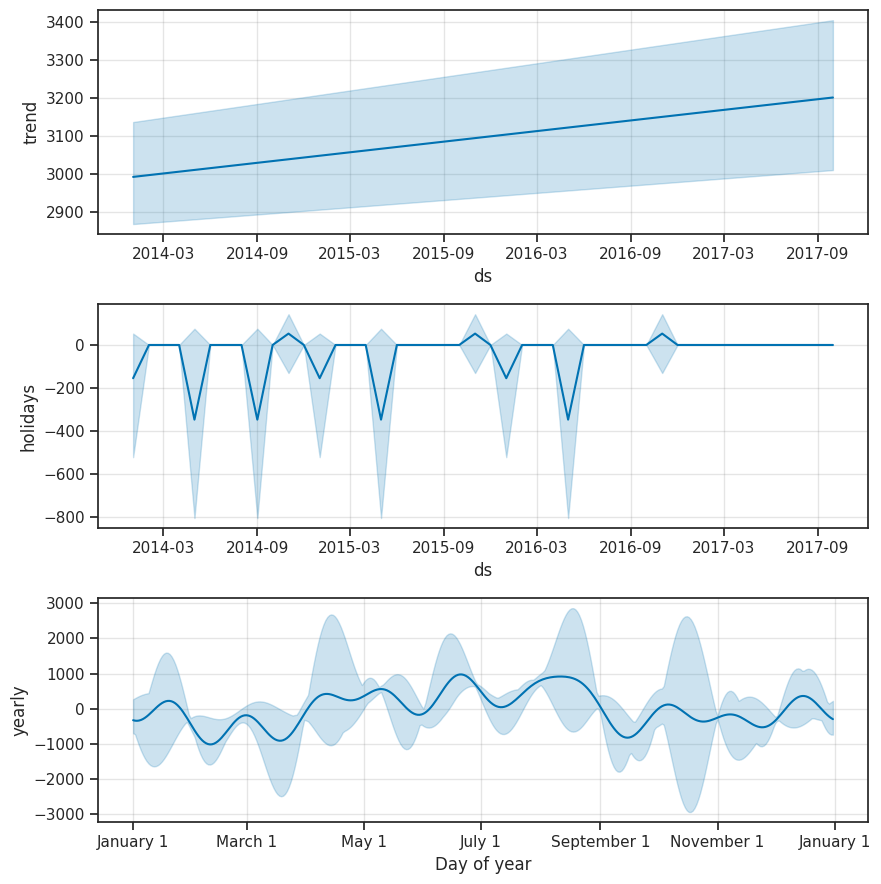

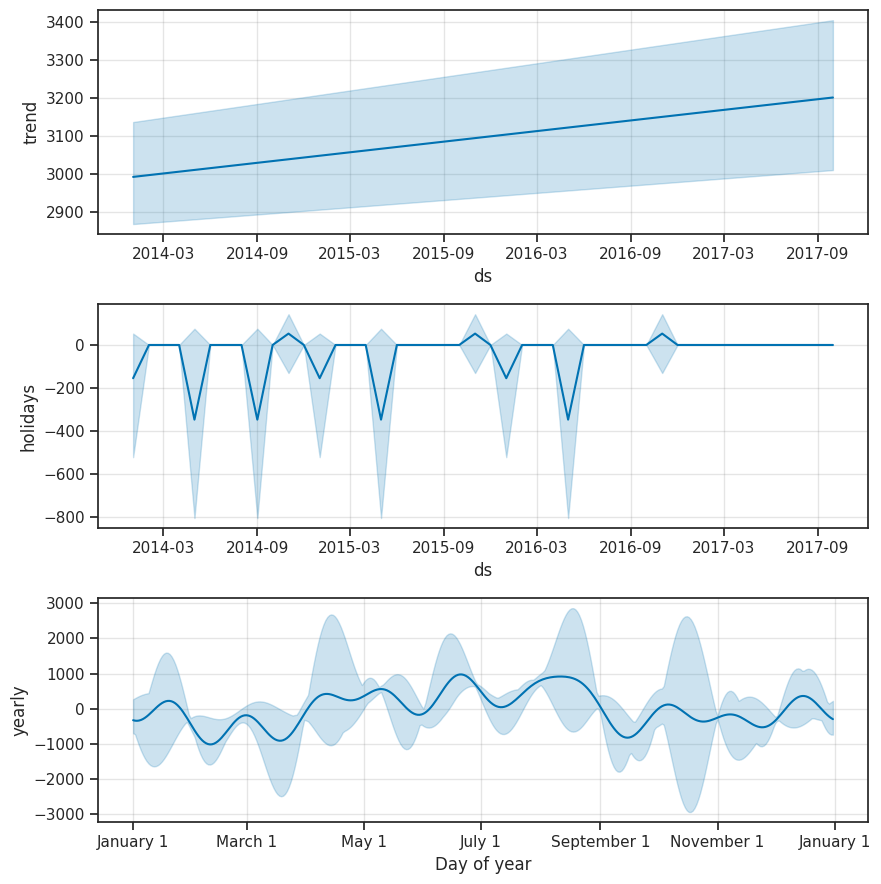

In [33]:
model.plot_components(forecast)

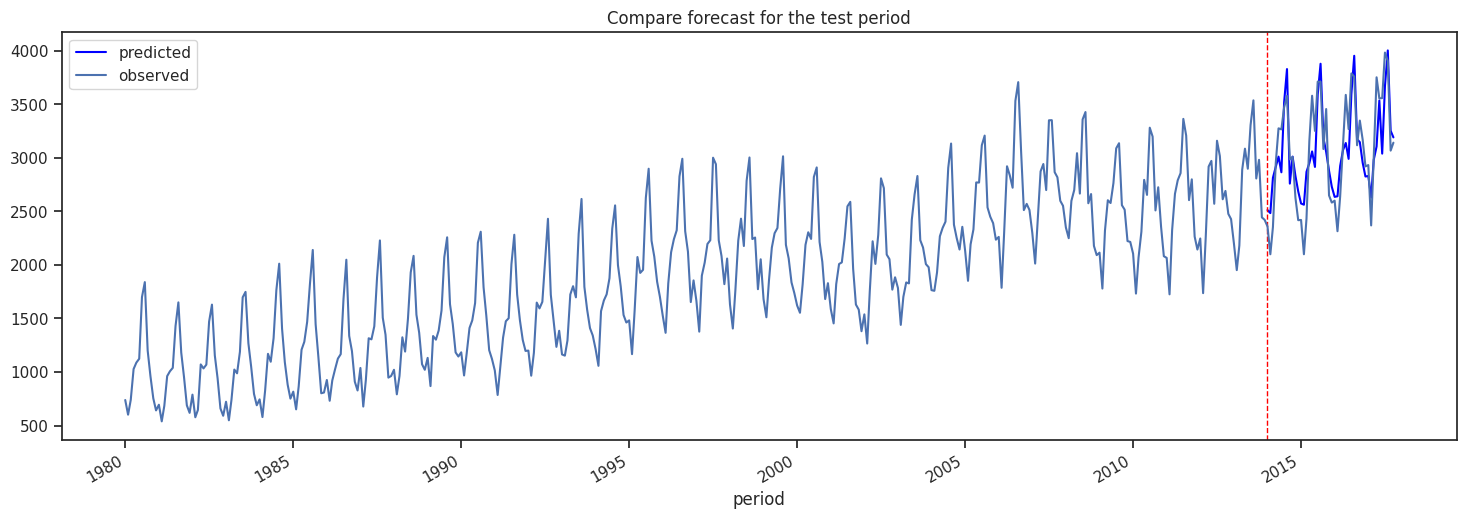

In [34]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
df.plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')
plt.show();

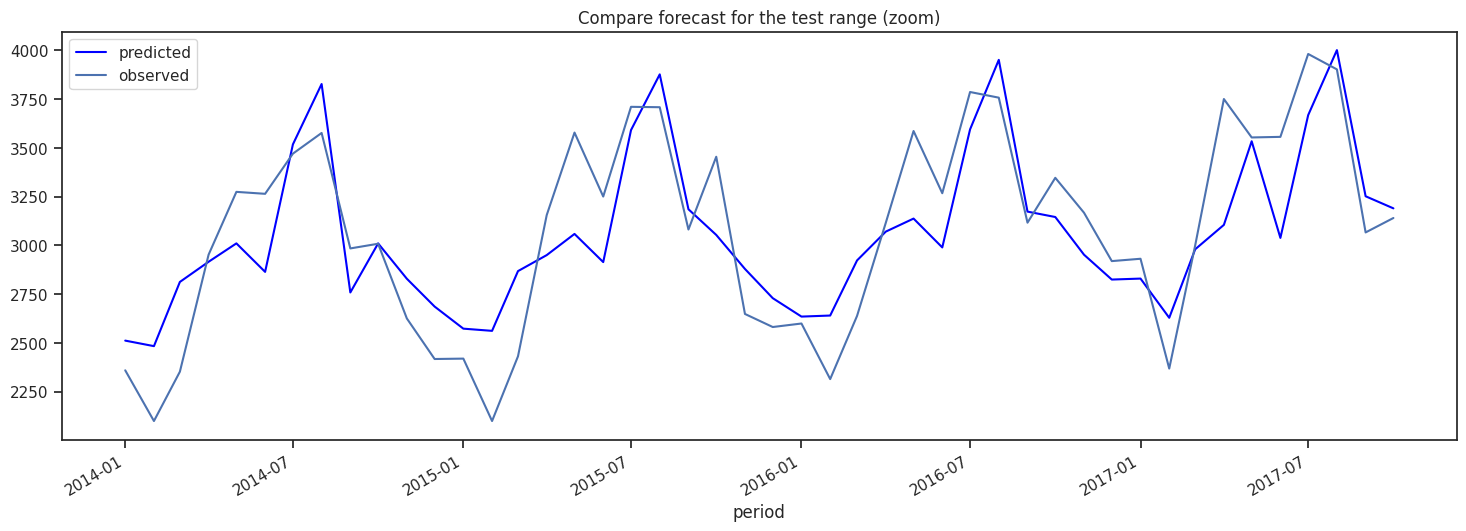

In [35]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range (zoom)')
plt.show();

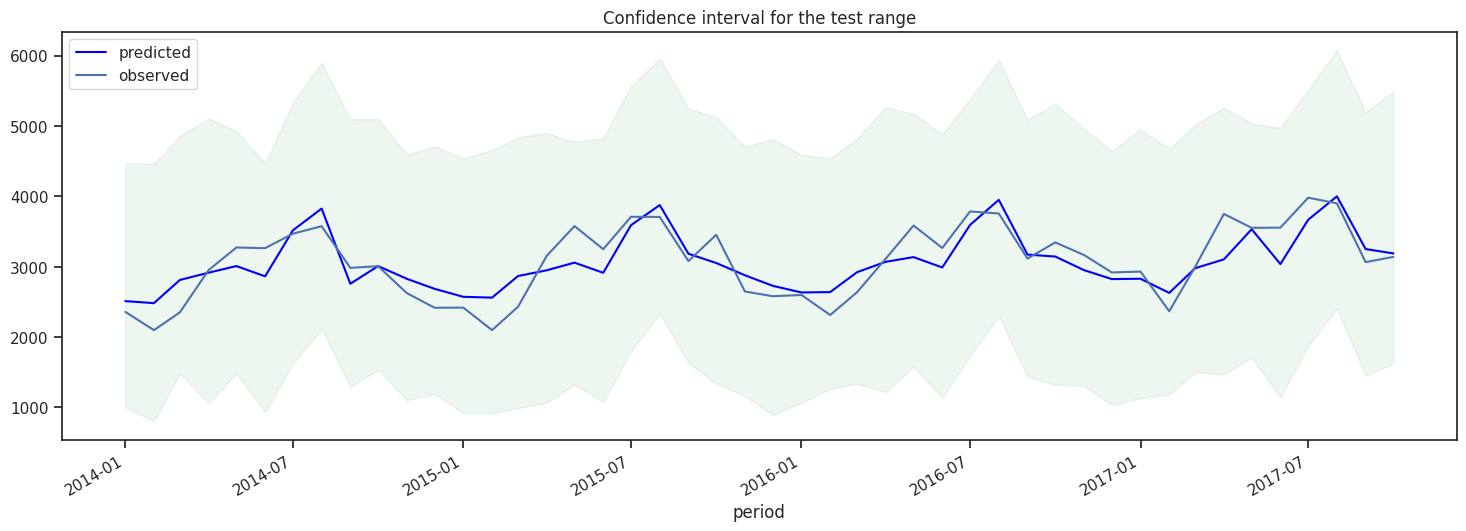

In [36]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    forecast_ci['yhat_lower'],
    forecast_ci['yhat_upper'],
    color='g',
    alpha=0.1)

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Confidence interval for the test range')
plt.show();

### <a id='toc1_4_4_'></a>[3.4 Evaluate the forecast](#toc0_)

Evaluating a forecast model using metrics like **Mean Absolute Error (MAE)**, **Mean Squared Error (MSE)**, and **R-squared (R2)** can provide valuable insights into the accuracy and performance of your model's predictions. Here's how you can calculate and interpret these metrics:

**Mean Absolute Error (MAE)**:
MAE measures the average absolute difference between the predicted values and the actual values. It gives you an idea of how close the forecasts are to the actual observations.

**Mean Squared Error (MSE)**:
MSE measures the average squared difference between the predicted values and the actual values. It penalizes larger errors more heavily than smaller errors.

**R-squared (R2)**:
R-squared, also known as the coefficient of determination, measures the proportion of the variance in the dependent variable that is explained by the independent variables (predictions). It provides an indication of how well the model's predictions fit the actual data.

In [37]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)

print("MAE (test): {:0.6f}".format(mae))
print("MSE (test): {:0.6f}".format(mse))
print("R2  (test): {:0.6f}".format(r2))

MAE (test): 229.619319
MSE (test): 76887.794696
R2  (test): 0.703306


# <a id='toc2_'></a>[4. Holt-Winters Model](#toc0_)

The Holt-Winters algorithm, also known as the Triple Exponential Smoothing method, is a time-series forecasting technique that employs exponential smoothing to make predictions based on past observations. It specifically addresses three primary components of a time series:

__Level__: The average value in the series.

__Trend__: The increasing or decreasing value in the series.

__Seasonality__: The repeating short-term cycle in the series.

Given these components, the Holt-Winters method utilizes three types of exponential smoothing:

__Simple Exponential Smoothing:__ Simple exponential smoothing as the name suggest is used for forecasting when the data set has no trends or seasonality

__Double Exponential Smoothing/Holt's Smoothing method__: This incorporates both the level and trend of the series.

__Triple Exponential Smoothing/Winter's Smoothing method__: This integrates the level, trend, and seasonality of the series.

Each smoothing method uses a smoothing parameter (alpha for level, beta for trend, and gamma for seasonality) to weigh the importance of the most recent observations when making forecasts <br>

Holt-Winters method is particularly suitable for data with strong seasonality, as it explicitly models the seasonal component, handle data with a linear trend and works well for short-term forecasting. <br>


Holt-Winters models use three equations to update these components over time:<br>

* __Level equation:__<br>
L(t) = alpha * (Y(t) - S(t-m)) + (1 - alpha) * (L(t-1) + T(t-1))<br>
<br>
* __Trend equation:__<br>
T(t) = beta * (L(t) - L(t-1)) + (1 - beta) * T(t-1)<br>
<br>
* __Seasonality equation:__<br>
S(t) = gamma * (Y(t) - L(t)) + (1 - gamma) * S(t-m)<br>
<br>
Where:<br>

* Y(t) is the observed value at time t<br>
* L(t) is the level (baseline) at time t<br>
* T(t) is the trend at time t<br>
* S(t) is the seasonality at time t<br>
* alpha, beta, and gamma are smoothing parameters between 0 and 1<br>
* m is the number of time periods in a season<br>

The model is initially fit to historical data, and then it forecasts future values based on the level, trend, and seasonality components. The choice of alpha, beta, gamma, and m can significantly impact the performance of the model, and finding appropriate values for these parameters often requires experimentation and optimization.<br>

Holt-Winters models can be extended to handle different variations, such as additive or multiplicative seasonality, and they are often used in various domains for demand forecasting, sales predictions, financial forecasting, and other time series prediction tasks<br>

We'll generate synthetic data to represent monthly sales data for a retail store

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL

# Generate a sample time series dataset with missing values and outliers
start_date = '2021-01-01'
end_date = '2023-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
num_data_points = len(date_range)

# Simulate monthly sales data with a seasonal pattern and an increasing trend
np.random.seed(42)
sales_trend = 10  # Trend parameter (increase in sales over time)
seasonal_pattern = np.sin(np.arange(num_data_points) * (2 * np.pi) / 6) * 50  # Monthly seasonality with 6 months per cycle
sales = 100 + sales_trend * np.arange(num_data_points) + seasonal_pattern + np.random.normal(0, 20, num_data_points)

# # Introduce missing values (randomly set some sales values to NaN)
# missing_indices = np.random.choice(num_data_points, size=int(num_data_points * 0.1), replace=False)
# sales[missing_indices] = np.nan

# # Introduce outliers (randomly add some extreme values)
# outlier_indices = np.random.choice(num_data_points, size=int(num_data_points * 0.05), replace=False)
# sales[outlier_indices] += np.random.normal(200, 50, len(outlier_indices))

# Create a DataFrame with the time series data
data = {
    'timestamp': date_range,
    'sales': sales
}
df = pd.DataFrame(data)
df.set_index('timestamp', inplace=True)

# Print the first few rows of the dataset
print(df.head())

                 sales
timestamp             
2021-01-31  109.934283
2021-02-28  150.535984
2021-03-31  176.255041
2021-04-30  160.460597
2021-05-31   92.015662


Now that we have generated the sample dataset, let's apply missing value treatment and the Holt-Winters algorithm to forecast future sales using the generated data

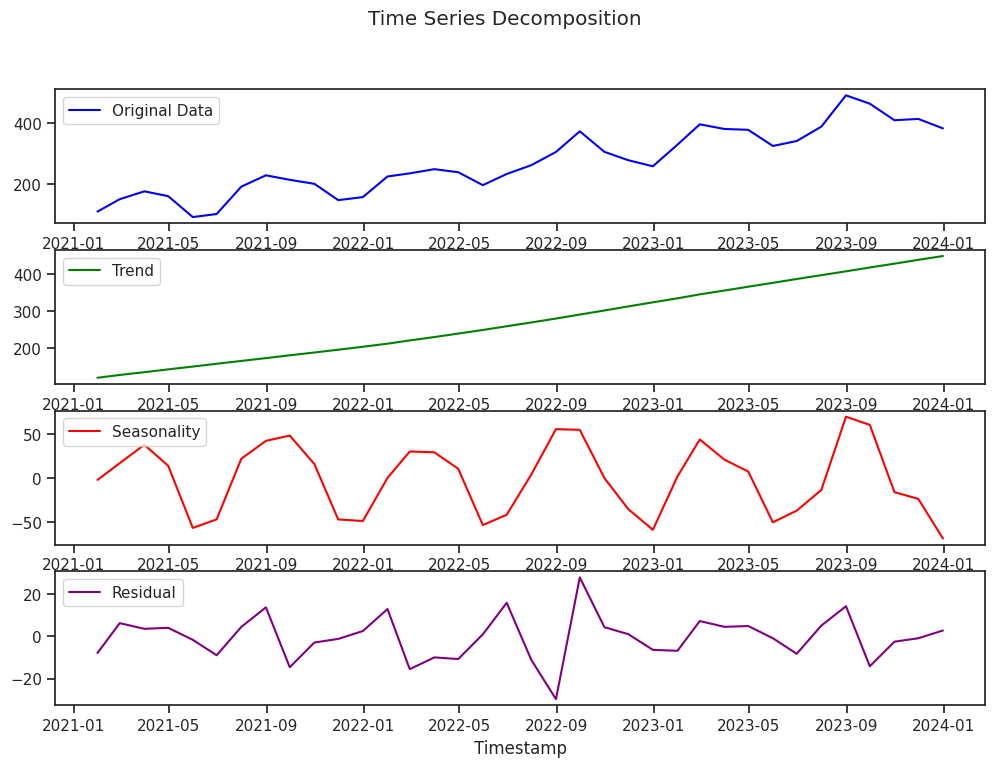

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


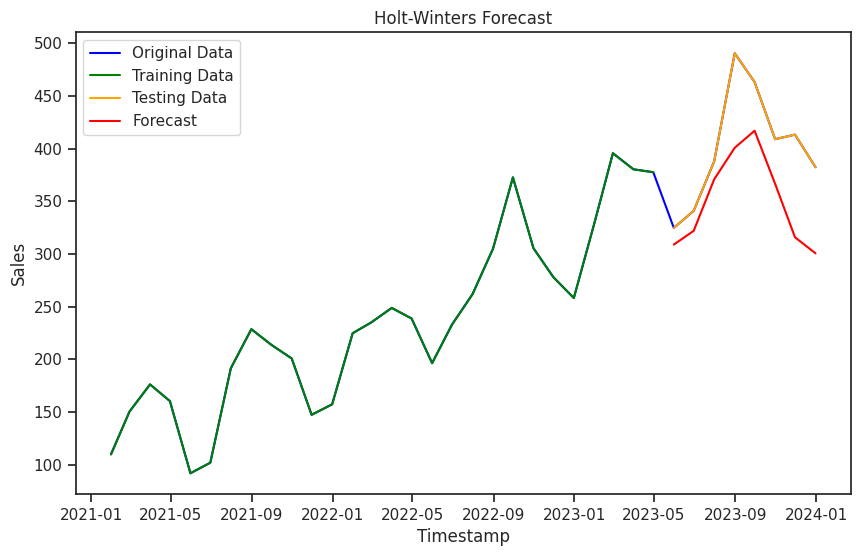

In [43]:
# Handle missing values by filling them using forward fill (ffill) method
df['sales_filled'] = df['sales'].fillna(method='ffill')

# Decompose the time series into trend, seasonality, and noise components using STL
decomposition = STL(df['sales_filled'], seasonal=13)  # 13-month seasonal period (adjust according to your data)
result = decomposition.fit()

# Extract the trend, seasonal, and residual components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the original data, trend, seasonality, and noise components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(df.index, df['sales_filled'], label='Original Data', color='blue')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(df.index, trend, label='Trend', color='green')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(df.index, seasonal, label='Seasonality', color='red')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(df.index, residual, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.xlabel('Timestamp')
plt.suptitle('Time Series Decomposition')
plt.show()


# Split the data into training and testing sets (80% for training, 20% for testing)
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Create the Holt-Winters model with additive seasonality
model = ExponentialSmoothing(train_data['sales_filled'], seasonal='add', seasonal_periods=12)  # Adjust seasonal_periods to 12
# Fit the model to the data
fitted_model = model.fit()

# Define the number of steps to forecast (number of future periods to predict)
forecast_horizon = len(test_data)
# Make predictions for the future (forecast_horizon) periods
forecast_values = fitted_model.forecast(forecast_horizon)

# Plot the original data, training data, testing data, and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['sales_filled'], label='Original Data', color='blue')
plt.plot(train_data.index, train_data['sales_filled'], label='Training Data', color='green')
plt.plot(test_data.index, test_data['sales_filled'], label='Testing Data', color='orange')
plt.plot(test_data.index, forecast_values, label='Forecast', color='red')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Sales')
plt.title('Holt-Winters Forecast')
plt.show()

In [40]:
# Calculate the Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

mape = calculate_mape(test_data['sales'], forecast_values)
print(f"MAPE: {mape:.2f}%")

MAPE: 14.38%


By visually inspecting the plot and analyzing the MAPE, you can evaluate the performance of the Holt-Winters model on the test data. Remember that in practical applications, you may want to use more advanced validation techniques to obtain a more robust evaluation of the model's performance

__Advantages:__<br>

* Particularly suitable for data with strong seasonality, as it explicitly models the seasonal component
* It can handle data with a linear trend or level
* Relatively simple and computationally efficient
* Works well for short-term forecasting

__Disadvantages:__<br>

* May not perform well with irregular or non-seasonal data<br>
* Does not handle outliers well, as it relies on smoothing techniques<br>

# <a id='toc3_'></a>[5. ARIMA Model](#toc0_)

In this section, we are going to discuss briefly about ARIMA

ARIMA stands for AutoRegressive Integrated Moving Average. It's a widely used time series forecasting method that combines autoregressive (AR) and moving average (MA) components with differencing to handle non-stationary data. ARIMA models are powerful tools for modeling and predicting time series data, including those with trends, seasonality, and other complex patterns.

ARIMA models are typically denoted as ARIMA(p, d, q), where:

p: The number of autoregressive terms (lags of the dependent variable).
d: The number of differences needed to make the data stationary.
q: The number of moving average terms (lags of the forecast errors).
Here's a breakdown of the components:

AutoRegressive (AR) Component:
The autoregressive component models the relationship between the current value of the time series and its past values. It assumes that the current value is linearly dependent on previous values with a lag. The parameter p determines the number of lags to consider. An AR(p) model can be expressed as:

scss
Copy code
y(t) = c + φ₁*y(t-1) + φ₂*y(t-2) + ... + φₚ*y(t-p) + ε(t)
Integrated (I) Component:
The integrated component deals with the differencing of the time series data to make it stationary. Differencing involves subtracting the current value from a lagged value to remove trends or seasonality. The parameter d represents the number of times the data is differenced. If the data is already stationary, d is set to 0.

Moving Average (MA) Component:
The moving average component models the relationship between the current value of the time series and past forecast errors. It captures short-term fluctuations and irregularities in the data. The parameter q determines the number of lagged forecast errors to consider.

An MA(q) model can be expressed as:


y(t) = c + θ₁*ε(t-1) + θ₂*ε(t-2) + ... + θₚ*ε(t-q) + ε(t)

The ARIMA model combines these components to create a model that accounts for autoregressive behavior, moving average behavior, and differencing to stabilize the data. It's important to choose appropriate values for p, d, and q based on the characteristics of your data. This often involves analyzing autocorrelation and partial autocorrelation plots to guide parameter selection.

ARIMA models are widely used for time series forecasting due to their flexibility and ability to capture a variety of temporal patterns. However, they might not work well for complex data with nonlinear patterns or long-term dependencies. In such cases, more advanced models like SARIMA (Seasonal ARIMA) or machine learning techniques might be more suitable.

__In summary, here are some guidelines for choosing the appropriate method:__<br>

* Use Holt-Winters for strongly seasonal data with linear trends and short-term forecasting needs.
* Use Prophet for user-friendly, long-term forecasting tasks with seasonality but not necessarily multiple seasonalities.

It's important to note that no single method is universally superior, and a proper evaluation of forecasting models, including cross-validation and performance metrics, is crucial to determine the best approach for a specific dataset and forecasting task.

Additionally, machine learning techniques like neural networks (e.g., LSTM) can also be considered for more complex time series data and forecasting scenarios.